In [1]:
#!/usr/bin/env python3.4

import os
import sys
import re
import uuid
import random
import imageio
import numpy as np
import torch
import torch_scatter
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.transforms as T

# torch.multiprocessing.set_start_method(method='spawn', force=True)

os.environ['CUDA_VISIBLE_DEVICES'] = '3'
sys.path.append('../')

from scipy import misc
from PIL import Image
from tqdm import tqdm
from omegaconf import OmegaConf, DictConfig
from evaluation import eval_utils as eu
from plugin.VidToMe.utils import save_video
from plugin.FastBlend.api import smooth_video
from utils.flow_utils import warp_flow, get_mask_bwds, compute_fwdbwd_mask

/tmp/ipykernel_5011/2009594869.py:21: DeprecationWarning: scipy.misc is deprecated and will be removed in 2.0.0
  from scipy import misc
/data1/jing_li/anaconda3/envs/iclight-bkup/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [37]:
output_dir = "../workdir/agirobot_digital/agirobot_digitaltwin_5_natural_lmr_0.9_gmr_0.8_vox_None"
config = OmegaConf.load(os.path.join(output_dir, 'config.yaml'))

if config.data.scene_type.lower() == "sceneflow":
    from utils.dataparsers import SceneFlowDataParser
    config.data.data_dir = os.path.join('../', config.data.data_dir)  # update relative path for notebook
    data_parser = SceneFlowDataParser(config.data, config.device)
elif config.data.scene_type.lower() == "video":
    from utils.dataparsers import VideoDataParser
    config.data.rgb_path = os.path.join('../', config.data.rgb_path).replace('agirobot', 'agibot')  # update relative path for notebook
    data_parser = VideoDataParser(config.data, config.device)
else:
    raise NotImplementedError(f"Scene type {config.scene_type} is not supported.")

frame_ids = eu.get_frame_ids(config.generation.frame_range, config.generation.frame_ids)
org_frames, _, _, flows, past_flows, mask_bwds =  data_parser.load_video(frame_ids, rgb_threshold=2/255)  

[INFO] frame indexes:  0 2 ... 438 440
[INFO] loaded video with 221 frames from: ../data/agibot_digital/observations/digitaltwin_5/1e01900f-798b-467f-bf60-e227c3ae3073/video/head.mp4
[INFO] frame size (480, 640) resize to (480, 640) and centercrop to (480, 640)
[INFO] Saving future flows to ../data/agibot_digital/observations/digitaltwin_5/1e01900f-798b-467f-bf60-e227c3ae3073/video/head_future_flow as .pt files
[INFO] Saving past flows to ../data/agibot_digital/observations/digitaltwin_5/1e01900f-798b-467f-bf60-e227c3ae3073/video/head_past_flow as .pt files


Loading Flows: 100%|██████████| 221/221 [00:00<00:00, 429.58it/s]


[INFO] frame size (480, 640) resize to (480, 640) and centercrop to (480, 640)
[INFO] frame size (480, 640) resize to (480, 640) and centercrop to (480, 640)


Assigning flow ids: 100%|██████████| 220/220 [00:00<00:00, 812.85it/s]


[INFO] Scatter with Time Dimention.
Total number of unique voxels: 8171820 / 67891200


## 0. Cluster Points according to Flow

In [3]:
pil_list = eu.video_to_pil_list(f'{output_dir}/output.gif')
edited_images = torch.concat([eu.load_image(pil, flows.device, flows.dtype) for pil in pil_list], dim=0) / 255.0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 639.5, 479.5, -0.5)

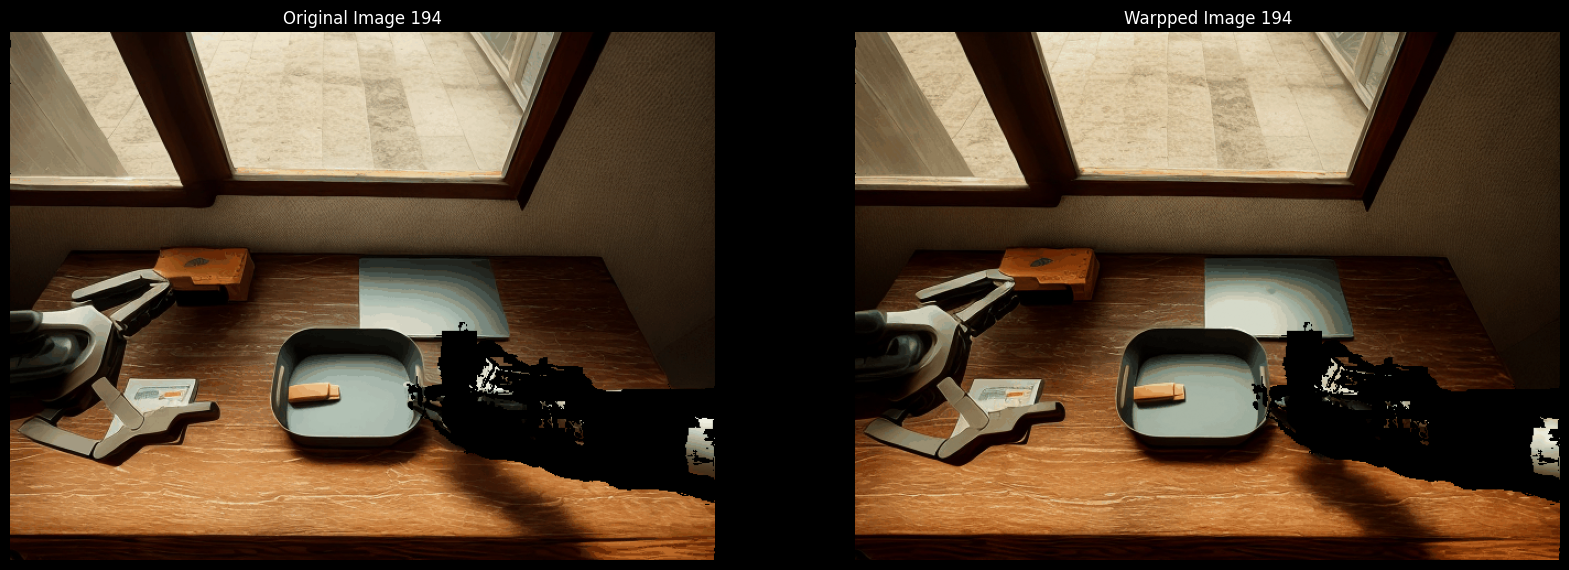

In [4]:
# analyze flow accuracy

idx = random.randint(1, len(frame_ids) - 1)
# idx = 101
with torch.no_grad():
    curr_image = edited_images[idx:idx+1].clone()
    warped_image = warp_flow(edited_images[idx-1:idx], past_flows[idx:idx+1])

    curr_image[~mask_bwds[idx:idx+1]] = 0
    warped_image[~mask_bwds[idx:idx+1]] = 0

    curr_image_np = curr_image[0].cpu().numpy().transpose(1, 2, 0)
    warped_image_np = warped_image[0].cpu().numpy().transpose(1, 2, 0)

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(curr_image_np)
plt.title(f'Original Image {idx}')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(warped_image_np)
plt.title(f'Warpped Image {idx}')
plt.axis('off')

In [5]:
frames = edited_images
N, _, H, W = frames.shape
feats_rgb = frames.permute(0, 2, 3, 1).reshape(-1, 3)
feats_rgb = torch_scatter.scatter(feats_rgb, data_parser.unq_inv, dim=0, reduce='mean')
new_frames = feats_rgb[data_parser.unq_inv].reshape(N, H, W, 3).permute(0, 3, 1, 2)

(-0.5, 639.5, 479.5, -0.5)

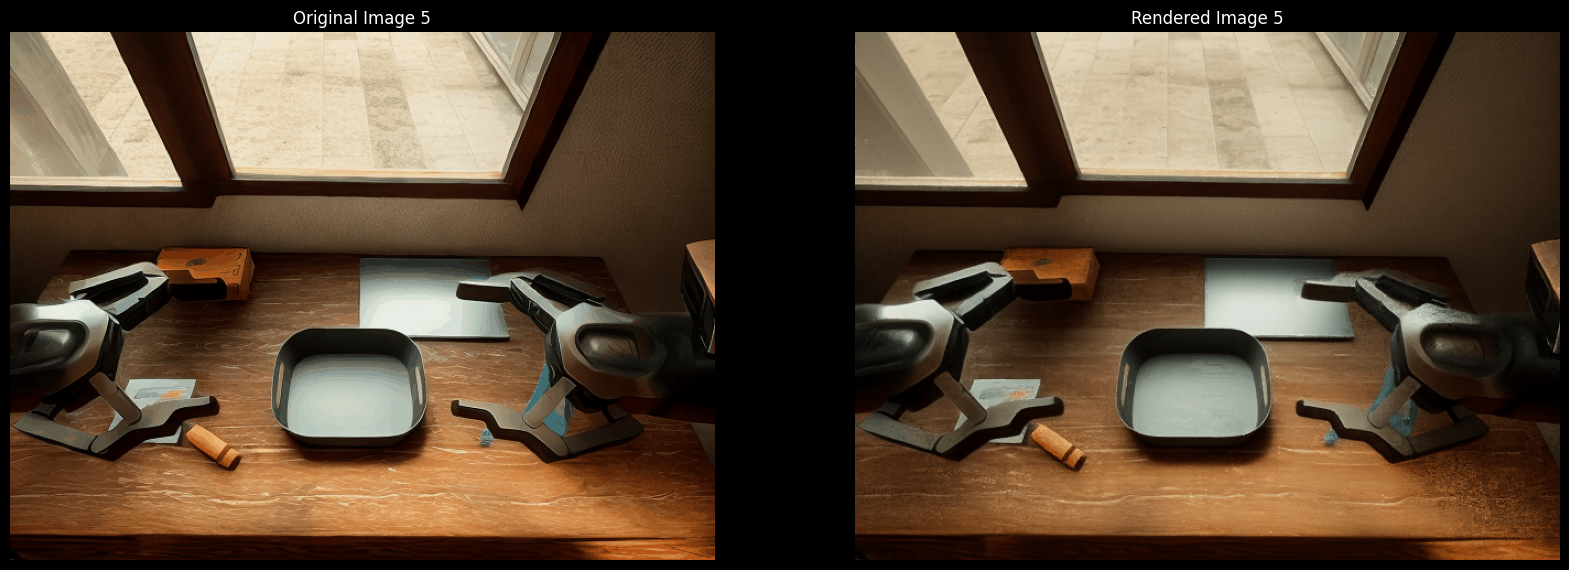

In [6]:
idx = random.randint(0, len(frame_ids) - 1)
idx = 5
pil_img = frames[idx].cpu().numpy().transpose(1, 2, 0)
rendered_img = new_frames[idx].cpu().numpy().transpose(1, 2, 0)

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(pil_img)
plt.title(f'Original Image {idx}')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(rendered_img)
plt.title(f'Rendered Image {idx}')
plt.axis('off')

(-0.5, 220.5, 479.5, -0.5)

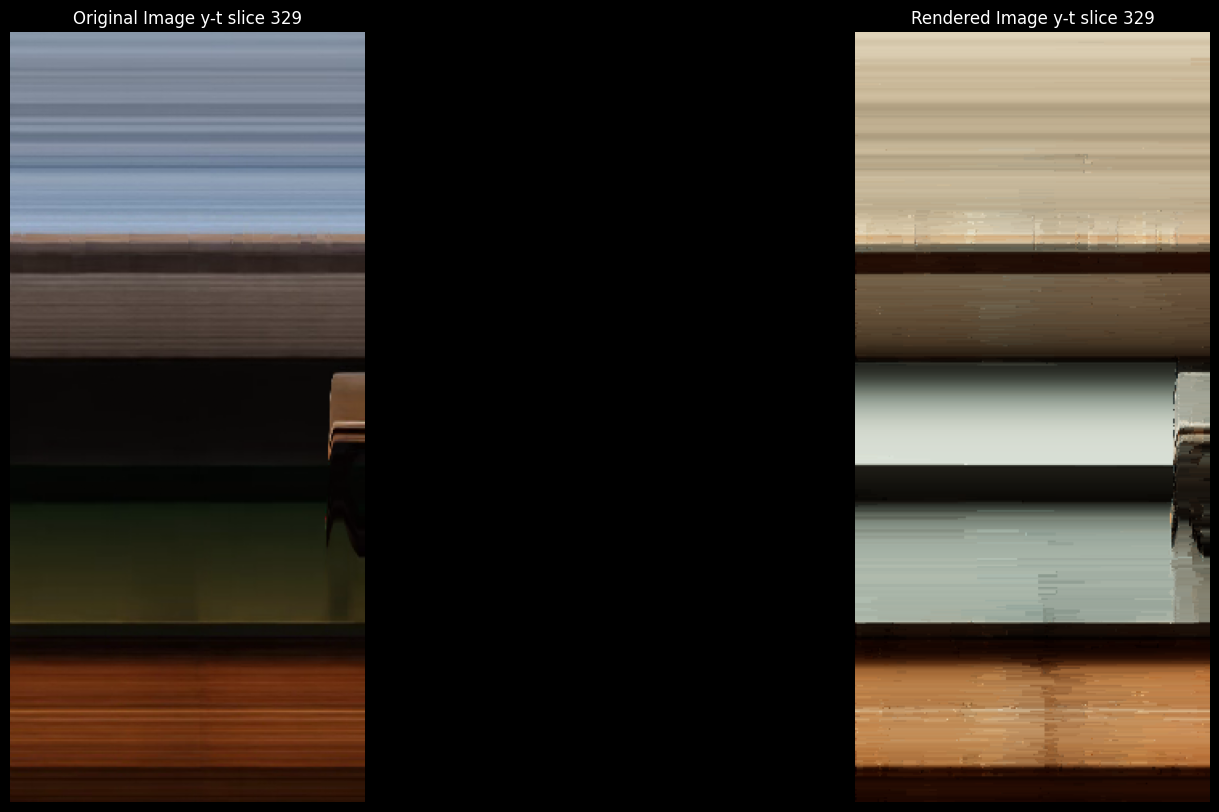

In [7]:
# analyze y-t slice
idx = random.randint(0, W - 1)
y_t_slice = org_frames.permute(3, 1, 2, 0)[idx].cpu().numpy().transpose(1, 2, 0)
new_y_t_slice = new_frames.permute(3, 1, 2, 0)[idx].cpu().numpy().transpose(1, 2, 0)

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(y_t_slice)
plt.title(f'Original Image y-t slice {idx}')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(new_y_t_slice)
plt.title(f'Rendered Image y-t slice {idx}')
plt.axis('off')


In [8]:
save_video(new_frames, os.path.join(output_dir, 'unique'), save_frame=True)

[INFO] save video to ../workdir/agirobot_digital/agirobot_digitaltwin_5_natural_lmr_0.9_gmr_0.8_vox_None/unique/output.gif


## 1. Train without Flow

In [39]:
import datetime
import torchvision
import piqa
from torch import nn
from torchvision.transforms.functional import rgb_to_grayscale
from utils.sh_utils import RGB2SH, SH2RGB, eval_sh
from utils.general_utils import get_expon_lr_func
from utils.loss_utils import l1_loss, l2_loss, depth_loss_dpt, VGGPerceptualLoss, TVLoss, relaxed_ms_ssim
from utils.dataloader import OptDataset
from utils.RIFE.IFNet_HDv4 import IFNet

# vgg_loss = VGGPerceptualLoss(resize=False)
max_sh_degree = 3
lambda_dssim = 0.2
lambda_slice = 0.1
d_final_factor = 0.1
lambda_exp = 0.8
epochs_exposure = 35
epochs = 70
batch_size = 16
iterations = epochs_exposure * len(frame_ids) // batch_size

feature_lr = 0.05 * batch_size / len(frame_ids)
exposure_lr_init = 0.01
exposure_lr_final = 0.001
exposure_lr_delay_steps = 0
exposure_lr_delay_mult = 0.0

interpolater = IFNet(ckpt_path="../models/rife/flownet_v4.22.pkl").to(data_parser.device).eval()

In [40]:
from torch.utils.data import Dataset

def calculate_cross_correlation(img1, img2, block_size=16, stride=4, eps=1e-8, size_average=True):
    """
    Calculate cross-correlation between two images using 16x16 blocks with 75% overlap.

    Args:
        img1 (Tensor): Input image tensor of shape (B, 3, H, W).
        img2 (Tensor): Input image tensor of shape (B, 3, H, W).
        block_size (int): Size of each block (default: 16).
        stride (int): Stride for overlapping blocks (default: 4 for 75% overlap).
        eps (float): Small value to avoid division by zero.
        size_average (bool): If True, return the average cross-correlation (default: True).

    Returns:
        Tensor: Scalar value representing the average cross-correlation.
    """
    # Ensure the input tensors are 4D (1x3xHxW)
    assert img1.dim() == 4 and img2.dim() == 4, "Inputs must be 4D tensors (1x3xHxW)"
    assert img1.shape == img2.shape, "Input images must have the same shape"

    # Unfold the images into blocks
    blocks1 = img1.unfold(2, block_size, stride).unfold(3, block_size, stride)
    blocks2 = img2.unfold(2, block_size, stride).unfold(3, block_size, stride)

    _, _, num_blocks_h, num_blocks_w, _, _ = blocks1.shape

    # Reshape to (num_blocks, channels, block_size, block_size)
    blocks1 = blocks1.permute(0, 2, 3, 1, 4, 5).contiguous().view(-1, 3, block_size, block_size)
    blocks2 = blocks2.permute(0, 2, 3, 1, 4, 5).contiguous().view(-1, 3, block_size, block_size)

    # Compute mean of each block and center
    mean1 = blocks1.mean(dim=(1, 2, 3), keepdim=True)
    mean2 = blocks2.mean(dim=(1, 2, 3), keepdim=True)
    a = blocks1 - mean1
    b = blocks2 - mean2

    # Compute cross-correlation for each block
    numerator = (a * b).sum(dim=(1, 2, 3))
    denominator = torch.sqrt((a.pow(2).sum(dim=(1, 2, 3)) * (b.pow(2).sum(dim=(1, 2, 3)))))
    
    # Return average cross-correlation
    cc = numerator / (denominator + eps)
    if size_average:
        return cc.mean()
    else:
        return cc.reshape(num_blocks_h, num_blocks_w)

@torch.jit.script_if_tracing
def sdsp(
    x: torch.Tensor,
    filtr: torch.Tensor,
    value_range: float = 1.0,
    sigma_c: float = 0.001,
    sigma_d: float = 145.0,
) -> torch.Tensor:
    r"""Detects salient regions from :math:`x`.

    Args:
        x: An input tensor, :math:`(N, 3, H, W)`.
        filtr: The frequency domain filter, :math:`(H, W)`.
        value_range: The value range :math:`L` of the input (usually 1 or 255).

    Note:
        For the remaining arguments, refer to Zhang et al. (2013).

    Returns:
        The visual saliency tensor, :math:`(N, H, W)`.

    Example:
        >>> x = torch.rand(5, 3, 256, 256)
        >>> filtr = sdsp_filter(x)
        >>> vs = sdsp(x, filtr)
        >>> vs.shape
        torch.Size([5, 256, 256])
    """

    x_lab = piqa.vsi.xyz_to_lab(piqa.vsi.rgb_to_xyz(x, value_range))

    # Frequency prior
    x_f = piqa.vsi.fft.ifft2(piqa.vsi.fft.fft2(x_lab) * filtr).real
    s_f = piqa.vsi.l2_norm(x_f, dim=1)

    # Color prior
    x_ab = x_lab[:, 1:]

    lo = x_ab.flatten(-2).min(dim=-1).values
    up = x_ab.flatten(-2).max(dim=-1).values

    lo = lo.reshape(lo.shape + (1, 1))
    up = up.reshape(lo.shape)

    x_ab = (x_ab - lo) / (up - lo + 1e-8)

    s_c = 1 - torch.exp(-x_ab.square().sum(dim=1) / sigma_c ** 2)

    # Location prior
    a, b = [
        torch.arange(n).to(x) - (n - 1) / 2
        for n in x.shape[-2:]
    ]

    s_d = torch.exp(-(a[None, :] ** 2 + b[:, None] ** 2) / sigma_d ** 2)

    # Visual saliency
    # vs = s_f * s_c * s_d

    return s_f, s_c, s_d

class SliceDataset(Dataset):
    def __init__(self, edited_images, device, dtype=torch.float32):

        super(SliceDataset, self).__init__()

        self.edited_images = edited_images.to(dtype=dtype, device=device)
        self.device = device
        self.dtype = dtype

        if self.edited_images.max() > 1:
            self.edited_images = self.edited_images / 255.0  # normalise to [0, 1] for further optimization

        # initialise the linalg module for lazy loading
        torch.inverse(torch.ones((1, 1), device=self.device))

    def __len__(self):
        return len(self.edited_images)

    def __getitem__(self, idx):

        edited_image = self.edited_images[idx]
        idx_h = (self.edited_images.shape[2] * idx) // len(self.edited_images)
        idx_w = (self.edited_images.shape[3] * idx) // len(self.edited_images)

        return idx, idx_h, idx_w, edited_image
    

In [41]:
pil_list = eu.video_to_pil_list(f'{output_dir}/output.gif')
edited_images = torch.concat([eu.load_image(pil, flows.device, flows.dtype) for pil in pil_list], dim=0) / 255.0
N, _, H, W = edited_images.shape

dataset = OptDataset(
    edited_images,
    past_flows,
    mask_bwds,
    device=data_parser.device
)

data_loader = torch.utils.data.DataLoader(
    dataset, 
    batch_size=batch_size, 
    shuffle=True
)

del edited_images, pil_list, mask_bwds, flows, past_flows

In [42]:
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()
start_time = datetime.datetime.now()

loss_list_exposure = []
pbar = tqdm(total=epochs_exposure, desc="Optimizing Exposures")

exposure = nn.Parameter(torch.eye(3, 4, device="cuda")[None].repeat(len(frame_ids), 1, 1).requires_grad_(True))
exposure_optimizer = torch.optim.Adam([exposure])
exposure_scheduler_args = get_expon_lr_func(exposure_lr_init, exposure_lr_final,
                                            lr_delay_steps=exposure_lr_delay_steps,
                                            lr_delay_mult=exposure_lr_delay_mult,
                                            max_steps=iterations)

for epoch in range(epochs_exposure):
    for i, (idxs, _edited_images, _pre_edited_images, _past_flows, _mask_bwds) in enumerate(data_loader):

        iteration = epoch * len(frame_ids) // batch_size + i + 1
        for param_group in exposure_optimizer.param_groups:
            param_group['lr'] = exposure_scheduler_args(iteration)

        cat_images = torch.cat([_edited_images, _pre_edited_images], dim=0)
        cat_idxs = torch.cat([idxs, idxs-1], dim=0)
        cat_idxs[cat_idxs < 0] = 0

        cat_images = torch.bmm(cat_images.permute(0, 2, 3, 1).reshape(-1, H*W, 3), exposure[cat_idxs, :3, :3]) + exposure[cat_idxs, None, :3, 3]
        cat_images = torch.clamp(cat_images, 0, 1).reshape(-1, H, W, 3).permute(0, 3, 1, 2)  # N x 3 x H x W

        images = cat_images[:len(idxs)]
        pre_images = cat_images[len(idxs):]

        loss_photometric = l1_loss(images, _edited_images) * (1 - lambda_dssim) + \
                            (1.0 - relaxed_ms_ssim(images, _edited_images, data_range=1, start_level=1)) * lambda_dssim

        warped_images = warp_flow(pre_images, _past_flows)[idxs>0]
        images, _mask_bwds = images[idxs>0], _mask_bwds[idxs>0]

        loss_flow = l1_loss(warped_images[_mask_bwds], images[_mask_bwds])

        loss = (1 - lambda_exp) * loss_photometric + lambda_exp * loss_flow

        loss_list_exposure.append(loss.item())

        loss.backward()

        exposure_optimizer.step()
        exposure_optimizer.zero_grad(set_to_none = True)
    
    pbar.set_postfix(
        loss='{:3f}'.format(loss.item()), 
        loss_flow='{:3f}'.format(loss_flow.item()),
        loss_photometric='{:3f}'.format(loss_photometric.item())
    )
    pbar.update()

pbar.close()

dataset.exposure_align(exposure)

end_time = datetime.datetime.now()
max_memory_allocated = torch.cuda.max_memory_allocated() / (1024.0 ** 2)
print(f"Memory: {max_memory_allocated:.2f} MB")
print(f"Time: {(end_time - start_time).total_seconds()}s")

Optimizing Exposures: 100%|██████████| 35/35 [00:32<00:00,  1.08it/s, loss=0.028263, loss_flow=0.031387, loss_photometric=0.015767]

Memory: 7184.28 MB
Time: 32.48952s


In [2]:
input_dir = '../workdir/agirobot_digital/agirobot_digitaltwin_5_natural_lmr_0.9_gmr_0.8_vox_None/exposure'
mode = "Fast"
window_size = 15
batch_size = 16
guide_weight = 10.0
patch_size = 5
num_iter = 5

smooth_video(
    video_guide = os.path.join(input_dir, "output.mp4"),
    video_guide_folder = None,
    video_style = os.path.join(input_dir, "output.mp4"),
    video_style_folder = None,
    mode = mode,
    window_size = window_size,
    batch_size = batch_size,
    tracking_window_size = 1,
    output_path = os.path.join(input_dir, f"smoothed_{mode}_w{window_size}_b{batch_size}_g{guide_weight}_n{num_iter}_p{patch_size}"),
    fps = None,
    minimum_patch_size = patch_size,
    num_iter = num_iter,
    guide_weight = guide_weight,
    initialize = "identity"
)

Your video will be saved here: ../workdir/agirobot_digital/agirobot_digitaltwin_5_natural_lmr_0.9_gmr_0.8_vox_None/exposure/smoothed_Fast_w15_b16_g10.0_n5_p5


Fast Mode Step 4/4: 100%|██████████| 41/41 [01:00<00:00,  1.48s/it]


Fps: 15.0
Saving video...
Success!
Your frames are here: ../workdir/agirobot_digital/agirobot_digitaltwin_5_natural_lmr_0.9_gmr_0.8_vox_None/exposure/smoothed_Fast_w15_b16_g10.0_n5_p5/frames
Your video is here: ../workdir/agirobot_digital/agirobot_digitaltwin_5_natural_lmr_0.9_gmr_0.8_vox_None/exposure/smoothed_Fast_w15_b16_g10.0_n5_p5/video.mp4


('../workdir/agirobot_digital/agirobot_digitaltwin_5_natural_lmr_0.9_gmr_0.8_vox_None/exposure/smoothed_Fast_w15_b16_g10.0_n5_p5',
 15.0,
 '../workdir/agirobot_digital/agirobot_digitaltwin_5_natural_lmr_0.9_gmr_0.8_vox_None/exposure/smoothed_Fast_w15_b16_g10.0_n5_p5/video.mp4')

In [46]:
smooth_iteration = 20
input_images = dataset.edited_images

for k in tqdm(range(smooth_iteration), desc="Frames Smoothing"):
    if k % 2 == 0:
        edited_images = [input_images[0]]
        for i in range(1, N-2):
            # s_frame = input_images[i-1:i]
            s_frame = edited_images[-1][None]
            m_frame = input_images[i:i+1]
            e_frame = input_images[i+1:i+2]

            with torch.no_grad():
                interp_frames_s = interpolater.inference(s_frame, m_frame)
                interp_frames_e = interpolater.inference(m_frame, e_frame)
                interp_frames_m = interpolater.inference(interp_frames_s, interp_frames_e)

            edited_images.append(interp_frames_m[0])
        edited_images.append(input_images[-1])
    else:
        edited_images = [input_images[-1]]
        for i in range(N-2, 1, -1):
            e_frame = edited_images[0][None]
            m_frame = input_images[i:i+1]
            s_frame = input_images[i-1:i]

            with torch.no_grad():
                interp_frames_s = interpolater.inference(s_frame, m_frame)
                interp_frames_e = interpolater.inference(m_frame, e_frame)
                interp_frames_m = interpolater.inference(interp_frames_s, interp_frames_e)
            
            edited_images = [interp_frames_m[0]] + edited_images
        edited_images = [input_images[0]] + edited_images
    input_images = torch.stack(edited_images, dim=0)

save_name = f"rife_smoothed_{smooth_iteration}_ar"
cur_output_path = os.path.join(output_dir, save_name)
save_video(input_images, cur_output_path, save_frame=True, fps=15)
# copy output_dir/config.yaml and output_dir/output_gt.gif to cur_output_path
os.system(f"cp {os.path.join(output_dir, 'config.yaml')} {cur_output_path}")
os.system(f"cp {os.path.join(output_dir, 'output_gt.gif')} {cur_output_path}")

Frames Smoothing: 100%|██████████| 20/20 [01:38<00:00,  4.92s/it]


[INFO] save video to ../workdir/agirobot_digital/agirobot_digitaltwin_5_natural_lmr_0.9_gmr_0.8_vox_None/rife_smoothed_20_ar/output.gif


0

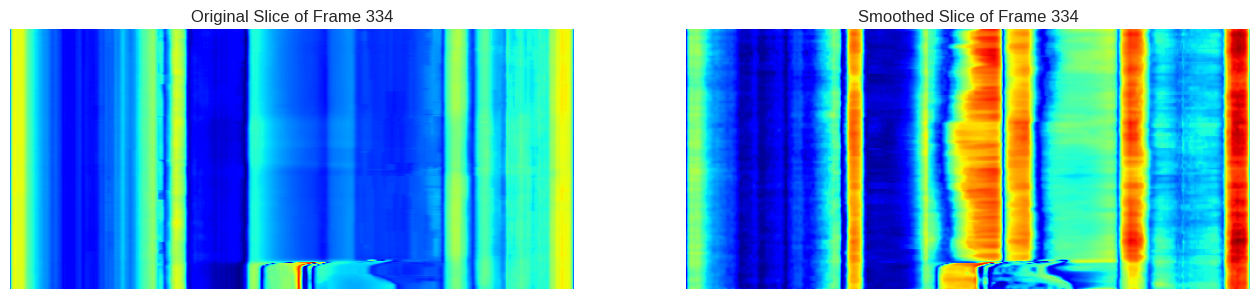

In [35]:
import torch
ANALYZE_SLICE= True
if ANALYZE_SLICE:
    axis = 'w'  # 'h', 'w'
    domain = 'f'  # 'f', 'c', 'd'
    vsi = piqa.VSI().cuda()
    filtr = piqa.vsi.sdsp_filter(org_frames)
    s_f_org, s_c_org, s_d_org = sdsp(org_frames, filtr)
    s_f_edited, s_c_edited, s_d_edited = sdsp(dataset.edited_images, filtr)

    if domain == 'f':
        feats_org = s_f_org
        feats_edited = s_f_edited
    else:
        feats_org = s_c_org
        feats_edited = s_c_edited

    if axis == 'h':
        idx = random.randint(0, H-1)
        org_image = org_frames[:, :, idx:idx+1, :].permute(2, 1, 0, 3)
        edited_image = dataset.edited_images[:, :, idx:idx+1, :].permute(2, 1, 0, 3)
        org_feat = feats_org[:, idx:idx+1, :].permute(1, 0, 2)
        edtied_feat = feats_edited[:, idx:idx+1, :].permute(1, 0, 2)
    else:
        idx = random.randint(0, W-1)
        org_image = org_frames[:, :, :, idx:idx+1].permute(3, 1, 0, 2)
        edited_image = dataset.edited_images[:, :, :, idx:idx+1].permute(3, 1, 0, 2)
        org_feat = feats_org[:, :, idx:idx+1].permute(2, 0, 1)
        edtied_feat = feats_edited[:, :, idx:idx+1].permute(2, 0, 1)


    plt.style.use("seaborn-v0_8-whitegrid")
    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.imshow(org_feat[0].cpu().numpy(), cmap='jet')
    # plt.imshow(org_image[0].permute(1, 2, 0).cpu().numpy())
    plt.title(f"Original Slice of Frame {idx}")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(edtied_feat[0].cpu().numpy(), cmap='jet')
    # plt.imshow(edited_image[0].permute(1, 2, 0).cpu().numpy())
    plt.title(f"Smoothed Slice of Frame {idx}")
    plt.axis("off")

    # mean_correlation = calculate_cross_correlation(org_image, edited_image, size_average=False).clamp(0, 0.9)
    # plt.figure()
    # plt.imshow(mean_correlation.cpu().numpy(), cmap='jet')
    # plt.title(f"Cross-Correlation of Frame {idx}")
    # plt.axis("off")


In [11]:
dataset = SliceDataset(
    input_images,
    device=data_parser.device
)

data_loader = torch.utils.data.DataLoader(
    dataset, 
    batch_size=batch_size, 
    shuffle=True
)

In [21]:
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()
start_time = datetime.datetime.now()
pbar.close()

with torch.no_grad():
    pil_tensor = dataset.edited_images.permute(0, 2, 3, 1).reshape(N*H*W, -1)
    # pil_tensor = torch_scatter.scatter(pil_tensor, data_parser.unq_inv, dim=0, reduce='mean')

vsi = piqa.VSI().cuda()
filtr = piqa.vsi.sdsp_filter(dataset.edited_images)
fused_color = RGB2SH(pil_tensor)
features_dc = nn.Parameter(fused_color.contiguous().requires_grad_(True))

l = [
    {'params': [features_dc], 'lr': feature_lr, "name": "f_dc"},
]
optimizer = torch.optim.Adam(l, lr=0.0, eps=1e-15)

loss_list = []

pbar = tqdm(total=epochs, desc="Optimizing Unique Tensor")

for epoch in range(epochs):
    # for i, (idxs, idxs_h, idx_w, _edited_images) in enumerate(data_loader):

    # step = epoch * len(frame_ids) // batch_size + i + 1
    images = SH2RGB(features_dc).reshape(N, H, W, -1).permute(0, 3, 1, 2).clamp(0, 1)  # N x 3 x H x W

    s_f_org, _, _ = sdsp(org_frames, filtr)
    s_f_edited, _, _ = sdsp(images, filtr)
    loss_slice = l1_loss(s_f_edited, s_f_org) * 0.005
    
    # loss = lambda_slice * loss_slice
    
    loss_photometric = (1.0 - relaxed_ms_ssim(images, dataset.edited_images, data_range=1, start_level=1)) * lambda_dssim

    loss = (1 - lambda_slice) * loss_photometric + lambda_slice * loss_slice

    loss_list.append([loss.item(), loss_photometric.item(), loss_flow.item()])

    loss.backward()

    optimizer.step()
    optimizer.zero_grad(set_to_none = True)
    
    pbar.set_postfix(
        loss='{:3f}'.format(loss.item()), 
        loss_slice='{:3f}'.format(loss_slice.item()),
        loss_photometric='{:3f}'.format(loss_photometric.item())
    )
    pbar.update()

pbar.close()

end_time = datetime.datetime.now()
max_memory_allocated = torch.cuda.max_memory_allocated() / (1024.0 ** 2)
print(f"Memory: {max_memory_allocated:.2f} MB")
print(f"Time: {(end_time - start_time).total_seconds()}s")

# images = SH2RGB(features_dc)[data_parser.unq_inv].reshape(N, H*W, -1) # N x HW x 3
images = SH2RGB(features_dc).reshape(N, H*W, -1) # N x HW x 3
images = torch.clamp(images, 0, 1).reshape(N, H, W, 3).permute(0, 3, 1, 2)  # N x 3 x H x W

Optimizing Unique Tensor:   0%|          | 0/70 [00:00<?, ?it/s]

Optimizing Unique Tensor: 100%|██████████| 70/70 [00:28<00:00,  2.46it/s, loss=0.001383, loss_photometric=-0.000987, loss_slice=0.022715]

Memory: 18158.19 MB
Time: 28.505395s


Text(0.5, 1.0, 'Loss curve for unique tensor optimization')

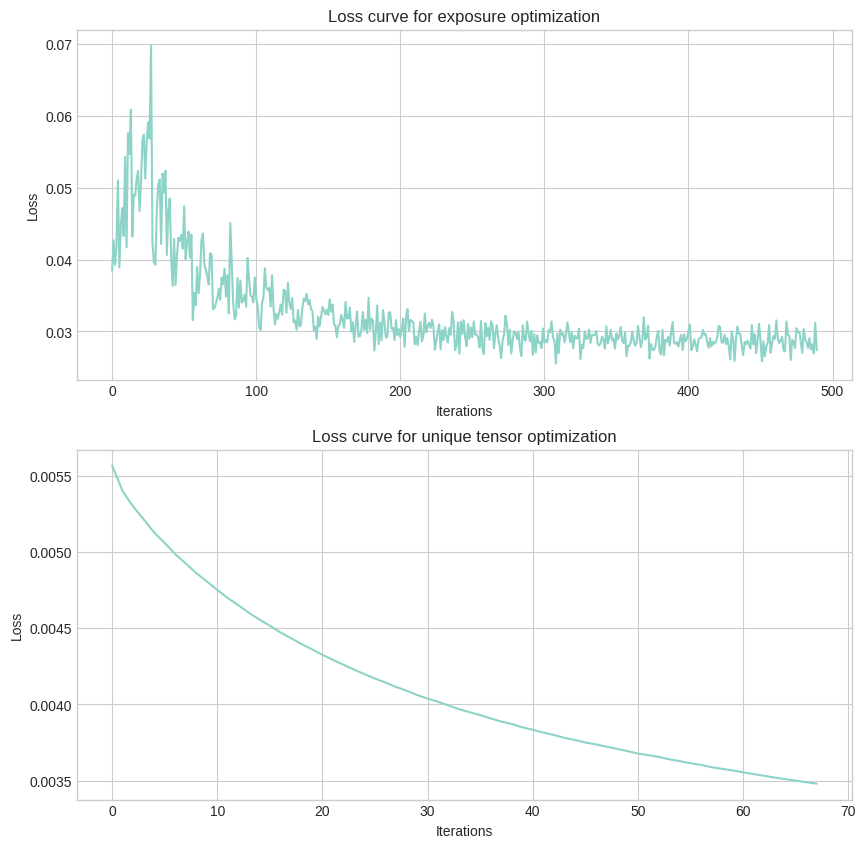

In [13]:
plt.style.use("seaborn-v0_8-whitegrid")
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(loss_list_exposure)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Loss curve for exposure optimization")

plt.subplot(2, 1, 2)
plt.plot(np.array(loss_list)[:, 0])
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Loss curve for unique tensor optimization")

In [40]:
SAVE=True
if SAVE:
    save_name = f"exposure"
    cur_output_path = os.path.join(output_dir, save_name)
    save_video(dataset.edited_images, cur_output_path, save_frame=True, fps=15, gif=False)
    save_video(org_frames, cur_output_path, save_frame=False, fps=15, gif=False, post_fix="_gt")
    # copy output_dir/config.yaml and output_dir/output_gt.gif to cur_output_path
    # os.system(f"cp {os.path.join(output_dir, 'config.yaml')} {cur_output_path}")
    # os.system(f"cp {os.path.join(output_dir, 'output_gt.gif')} {cur_output_path}")

[INFO] save video to ../workdir/agirobot_digital/agirobot_digitaltwin_5_natural_lmr_0.9_gmr_0.8_vox_None/exposure/output.mp4
[INFO] save video to ../workdir/agirobot_digital/agirobot_digitaltwin_5_natural_lmr_0.9_gmr_0.8_vox_None/exposure/output_gt.mp4


In [22]:
images_np = images.permute(0, 2, 3, 1).detach().cpu().numpy()
edited_images_np = dataset.edited_images.permute(0, 2, 3, 1).cpu().numpy()

(-0.5, 639.5, 479.5, -0.5)

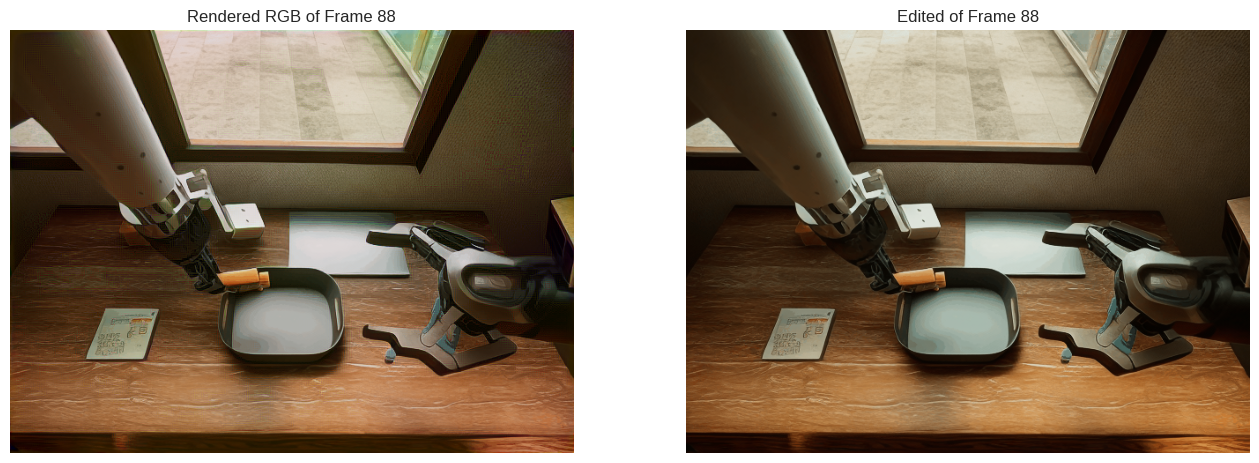

In [28]:
plt.style.use("seaborn-v0_8-whitegrid")
idx = random.randint(0, N-1)
# idx = 199

plt.figure(figsize=(16, 10))
plt.subplot(1, 2, 1)
plt.imshow(images_np[idx])
plt.title(f"Rendered RGB of Frame {idx}")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(edited_images_np[idx])
plt.title(f"Edited of Frame {idx}")
plt.axis("off")